# Logistic regression baseline

In [1]:
LABEL_COL = 'is_goal'

TRAIN_COLS_BASIC = [
    'period', 'goals_home', 'goals_away',
    'shooter_id', 'coordinate_x', 'coordinate_y', 'distance_from_net',
    'angle'
]

RANDOM_STATE = 1729

In [2]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression

sys.path.insert(0,'../src/training/')
from utils import clf_performance_metrics

from visuals import generate_shot_classifier_charts

In [3]:
def load_train_and_validation():
    train = pd.read_csv("../data/processed/train_processed.csv")
    val = pd.read_csv("../data/processed/validation_processed.csv")

    na_mask = train[TRAIN_COLS_BASIC+[LABEL_COL]].isnull().any(axis=1)
    print(f"dropping {na_mask.sum()} rows (of {len(train)} total) containing nulls from train")
    train = train[~na_mask]

    na_mask = val[TRAIN_COLS_BASIC+[LABEL_COL]].isnull().any(axis=1)
    print(f"dropping {na_mask.sum()} rows (of {len(val)} total) containing nulls from val")
    val = val[~na_mask]

    X_train = train[TRAIN_COLS_BASIC]
    Y_train = train[LABEL_COL].astype(int)

    X_val = val[TRAIN_COLS_BASIC]
    Y_val = val[LABEL_COL].astype(int)

    return X_train, Y_train, X_val, Y_val

def preprocess(X_train, X_val):
    scaler = sklearn.preprocessing.StandardScaler().fit(X_train.values)

    X_train_scaled = pd.DataFrame(
        data=scaler.transform(X_train.values),
        index=X_train.index,
        columns=X_train.columns
    )

    X_val_scaled = pd.DataFrame(
        data=scaler.transform(X_val.values),
        index=X_val.index,
        columns=X_val.columns
    )

    return X_train_scaled, X_val_scaled

In [4]:
X_train, Y_train, X_val, Y_val = load_train_and_validation()
X_train, X_val = preprocess(X_train, X_val)
    
y_trues, y_preds, y_probas = [], [], []
exp_names = ['logistic_regression_'+sub for sub in ['distance_only', 'angle_only', 'distance_and_angle']]

col_subsets = [['distance_from_net'], ['angle'], ['distance_from_net', 'angle']]

dropping 15 rows (of 202514 total) containing nulls from train
dropping 1 rows (of 50961 total) containing nulls from val


Processing logistic_regression_distance_only...
{'accuracy': 0.9052394034536891, 'f1_score': 0.0, 'precision': 0.0, 'recall': 0.0}
Processing logistic_regression_angle_only...
{'accuracy': 0.9052394034536891, 'f1_score': 0.0, 'precision': 0.0, 'recall': 0.0}
Processing logistic_regression_distance_and_angle...
{'accuracy': 0.9052394034536891, 'f1_score': 0.0, 'precision': 0.0, 'recall': 0.0}


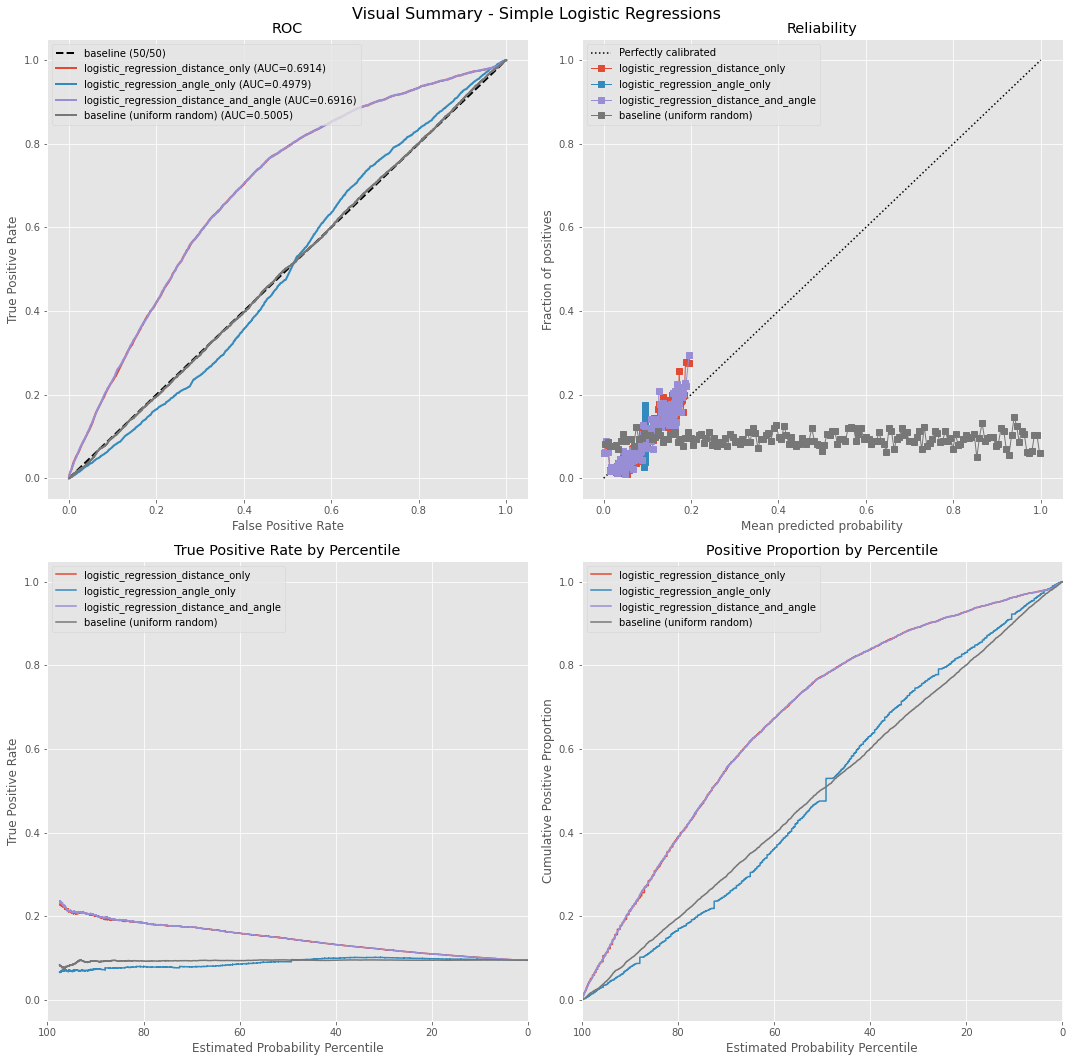

In [5]:
for exp_name, subset in zip(exp_names, col_subsets):
    print(f"Processing {exp_name}...")
    X_train_sub = X_train[subset].values
    X_val_sub = X_val[subset].values

    clf = LogisticRegression(random_state=RANDOM_STATE).fit(X_train_sub, Y_train)
    y_pred = clf.predict(X_val_sub)
    y_proba = clf.predict_proba(X_val_sub)[:,1]

    y_trues.append(Y_val)
    y_preds.append(y_pred)
    y_probas.append(y_proba)

    perf_metrics = clf_performance_metrics(Y_val, y_pred, y_proba, verbose=False)
    print(perf_metrics)
    
 # Adding the random baseline
exp_names.append('baseline (uniform random)')
y_trues.append(Y_val)
np.random.seed(RANDOM_STATE)
y_proba = np.random.uniform(low=0, high=1, size=len(Y_val))
y_probas.append(y_proba)
y_pred = (y_proba >=0.5).astype(int)
y_preds.append(y_pred)
    
title = "Visual Summary - Simple Logistic Regressions"
image_dir = "/home/sara/Downloads/DS_figures/"

generate_shot_classifier_charts(
        y_trues, y_preds, y_probas, exp_names,
        title=title, image_dir=image_dir
    )

# XGBoost baseline

In [4]:
import sys
import pandas as pd
import xgboost as xgb

sys.path.insert(0,'../src/training/')
from visuals import generate_shot_classifier_charts

RANDOM_STATE = 1729
TRAIN_COLS = ['distance_from_net', 'angle']
LABEL_COL = 'is_goal'

In [5]:
def load_train_and_validation():
    train = pd.read_csv("../data/processed/train_processed.csv")
    val = pd.read_csv("../data/processed/validation_processed.csv")

    xg_train = xgb.DMatrix(
        data = train[TRAIN_COLS],
        label = train[LABEL_COL].astype(int)
    )
    xg_train.save_binary('../data/processed/train_simple.buffer')
    xg_train = xgb.DMatrix('../data/processed/train_simple.buffer')

    xg_val = xgb.DMatrix(
        data = val[TRAIN_COLS],
        label = val[LABEL_COL].astype(int)
    )
    xg_val.save_binary('../data/processed/val_simple.buffer')
    xg_val = xgb.DMatrix('../data/processed/val_simple.buffer')

    return xg_train, xg_val

In [3]:
xg_train, xg_val = load_train_and_validation()

param = {
    'max_depth':2, 'eta':1, 'objective':'binary:logistic',
    'eval_metric': 'logloss'
}

clf = xgb.train(param,xg_train, num_boost_round=100)

res = pd.DataFrame({
    'y_true': xg_val.get_label(),
    'y_preds': None,
    'y_proba': clf.predict(xg_val)
})

exp_name = "xgboost_distance_angle_only"
res.to_csv(f"/home/sara/Downloads/DS_xgboost/{exp_name}.csv", index=False)

# XGBoost Hyperparams Optimal

In [23]:
import sys
import pandas as pd
import xgboost as xgb

sys.path.insert(0,'../src/training/')
from utils import clf_performance_metrics
from visuals import generate_shot_classifier_charts

In [24]:
RANDOM_STATE = 1729
TRAIN_COLS = ['distance_from_net', 'angle']
LABEL_COL = 'is_goal'

INFREQUENT_STOPPAGE_EVENTS = [
    'PERIOD_START', 'PERIOD_READY', 'PERIOD_END', 'SHOOTOUT_COMPLETE', 'PERIOD_OFFICIAL', 'GAME_OFFICIAL', 'PENALTY', 'GOAL', 'CHALLENGE'
]

KNOWN_NON_TRAIN_COLS = [
    'game_id', 'event_index', 'description',
    'game_sec', 'time', 'time_remaining', 'date', 'prev_event_time_diff',
    'is_goal'
]

# TODO: throw out is_empty_net + associated rows?
# see https://piazza.com/class/krgt4sfrgfp278?cid=255
TRAIN_COLS_PART_4 = [
    'game_sec', 'period',
    'secondary_type',
    'coordinate_x', 'coordinate_y', 'distance_from_net', 'angle',
    'prev_event_type', 'angle_between_prev_event', 'distance_from_prev_event', 'prev_event_time_diff',
    'speed', 'is_rebound', 'rebound_angle', 'is_empty_net'
]  # 'period_type', 'shooter_team_name', 'shooter_id', 'goalie_name',

In [25]:
def load_train_and_validation():
    train = pd.read_csv("../data/processed/train_processed.csv")
    val = pd.read_csv("../data/processed/validation_processed.csv")

    X_train, Y_train =  train[TRAIN_COLS_PART_4], train[LABEL_COL].astype(int)
    X_val, Y_val = val[TRAIN_COLS_PART_4], val[LABEL_COL].astype(int)

    return X_train, Y_train, X_val, Y_val


def preprocess(X_train, X_val):
    # TODO: try working with categorical data directly on GPU
    # see "1.4.17 Categorical Data" in https://buildmedia.readthedocs.org/media/pdf/xgboost/latest/xgboost.pdf

    X_train['secondary_type'].replace({'Tip-in': 'Deflection'}, inplace=True)
    X_train['prev_event_type'].replace(
        to_replace=INFREQUENT_STOPPAGE_EVENTS, value = 'STOP', inplace=True
    )

    X_val['secondary_type'].replace({'Tip-in': 'Deflection'}, inplace=True)
    X_val['prev_event_type'].replace(
        to_replace=INFREQUENT_STOPPAGE_EVENTS, value = 'STOP', inplace=True
    )

    X_train = pd.get_dummies(X_train, ['shot', 'prev_event'])
    X_val = pd.get_dummies(X_val, ['shot', 'prev_event'])

    return X_train, X_val

In [26]:
X_train, Y_train, X_val, Y_val = load_train_and_validation()
X_train, X_val = preprocess(X_train, X_val)

# chosen via results of hparam optimization search
params = {
    'max_depth':1, 'n_estimators': 275, 'learning_rate': .1, 'gamma': .1,
    'objective':'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False
}

clf = xgb.XGBClassifier(**params)
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:,1]
res = pd.DataFrame({
    'y_true': Y_val,
    'y_preds': y_pred,
    'y_proba': y_proba
})

exp_name = "xgboost_optimal-updated"
res.to_csv(f"/home/sara/Downloads/DS_xgboost/{exp_name}.csv", index=False)

perf_metrics = clf_performance_metrics(Y_val, y_pred, y_proba, verbose=True)
perf_metrics

INFO:root:Accuracy is  0.919
INFO:root:Confusion Matrix:
 [[46000   132]
 [ 3976   853]]
INFO:root:F1 score is  0.293
INFO:root:Precision score is  0.866
INFO:root:Recall score is  0.177


{'accuracy': 0.9193893369439375,
 'f1_score': 0.29342965256277953,
 'precision': 0.8659898477157361,
 'recall': 0.17664112652723132}

# XGBoost Feature Selection

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xgboost as xgb

sys.path.insert(0,'../src/training/')
from utils import clf_performance_metrics
from visuals import generate_shot_classifier_charts

In [2]:
RANDOM_STATE = 1729
TRAIN_COLS = ['distance_from_net', 'angle']
LABEL_COL = 'is_goal'

INFREQUENT_STOPPAGE_EVENTS = [
    'PERIOD_START', 'PERIOD_READY', 'PERIOD_END', 'SHOOTOUT_COMPLETE', 'PERIOD_OFFICIAL', 
    'GAME_OFFICIAL', 'PENALTY', 'GOAL', 'CHALLENGE'
]

KNOWN_NON_TRAIN_COLS = [
    'game_id', 'event_index', 'description',
    'game_sec', 'time', 'time_remaining', 'date', 'prev_event_time_diff',
    'is_goal'
]

# TODO: throw out is_empty_net + associated rows?
# see https://piazza.com/class/krgt4sfrgfp278?cid=255
TRAIN_COLS_PART_4 = [
    'game_sec', 'period',
    'secondary_type',
    'coordinate_x', 'coordinate_y', 'distance_from_net', 'angle',
    'prev_event_type', 'angle_between_prev_event', 'distance_from_prev_event', 'prev_event_time_diff',
    'speed', 'is_rebound', 'rebound_angle', 'is_empty_net',
    'prev_event_x_coord', 'prev_event_y_coord',
]  # 'period_type', 'shooter_team_name', 'shooter_id', 'goalie_name',

In [3]:
def load_train_and_validation():
    train = pd.read_csv("../data/processed/train_processed.csv")
    val = pd.read_csv("../data/processed/validation_processed.csv")

    X_train, Y_train =  train[TRAIN_COLS_PART_4], train[LABEL_COL].astype(int)
    X_val, Y_val = val[TRAIN_COLS_PART_4], val[LABEL_COL].astype(int)

    return X_train, Y_train, X_val, Y_val


def preprocess(X_train, X_val):
    # TODO: try working with categorical data directly on GPU
    # see "1.4.17 Categorical Data" in https://buildmedia.readthedocs.org/media/pdf/xgboost/latest/xgboost.pdf

    X_train['secondary_type'].replace({'Tip-in': 'Deflection'}, inplace=True)
    X_train['prev_event_type'].replace(
        to_replace=INFREQUENT_STOPPAGE_EVENTS, value = 'STOP', inplace=True
    )

    X_val['secondary_type'].replace({'Tip-in': 'Deflection'}, inplace=True)
    X_val['prev_event_type'].replace(
        to_replace=INFREQUENT_STOPPAGE_EVENTS, value = 'STOP', inplace=True
    )

    X_train = pd.get_dummies(X_train, ['shot', 'prev_event'])
    X_val = pd.get_dummies(X_val, ['shot', 'prev_event'])

    return X_train, X_val

In [4]:
# hyperparams search
def get_xgboost_hparams_tuning(X, y, feat_select_method_name,
                               save_result_path="/home/sara/Downloads/DS_xgboost/"):

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', eval_metric='logloss', use_label_encoder=False
    )

    hparam_search_ranges = {
        "n_estimators": randint(100, 500),
        "max_depth": randint(1, 6),
        "colsample_bytree": uniform(.33, 1-.33),
        "subsample": uniform(0.5, 1-.5),
        "learning_rate": uniform(0.03, .67-.03),
        "gamma": uniform(0, 0.5)
    }

    search = RandomizedSearchCV(
        xgb_model, param_distributions=hparam_search_ranges,
        random_state=1729, n_iter=50, cv=5, verbose=2, n_jobs=1, return_train_score=True, refit=True
    )

    search.fit(X.values, y.values)

    search_results_summary = pd.DataFrame(search.cv_results_)
    search_results_summary.to_csv(os.path.join(save_result_path, feat_select_method_name + ".csv"))

    clf_optimal = search.best_estimator_
    opt_params={key:getattr(clf_optimal,key) for key in hparam_search_ranges}
    
    return clf_optimal


In [5]:
def scale_df(X_train, X_val):
    scaler = sklearn.preprocessing.StandardScaler().fit(X_train.values)

    X_train_scaled = pd.DataFrame(
        data=scaler.transform(X_train.values),
        index=X_train.index,
        columns=X_train.columns
    )

    X_val_scaled = pd.DataFrame(
        data=scaler.transform(X_val.values),
        index=X_val.index,
        columns=X_val.columns
    )

    return X_train_scaled, X_val_scaled

In [6]:
X_train, Y_train, X_val, Y_val = load_train_and_validation()
X_train, X_val = preprocess(X_train, X_val)

## Feature selection: Lasso

In [7]:
import sklearn
from sklearn import feature_selection
from sklearn import linear_model

from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

In [8]:
X_train = X_train.fillna(0)

In [13]:
selector = feature_selection.SelectFromModel(estimator=linear_model.Lasso(alpha=0.001)).fit(X_train, Y_train)
selected_feats = list(selector.get_feature_names_out())

In [14]:
selected_feats

['coordinate_x',
 'coordinate_y',
 'distance_from_net',
 'angle',
 'angle_between_prev_event',
 'distance_from_prev_event',
 'prev_event_time_diff',
 'speed',
 'is_rebound',
 'rebound_angle',
 'is_empty_net',
 'prev_event_x_coord',
 'shot_Backhand',
 'shot_Tip-In',
 'shot_Wrist Shot',
 'prev_event_FACEOFF',
 'prev_event_GIVEAWAY',
 'prev_event_HIT',
 'prev_event_SHOT']

In [10]:
len(selected_feats)

19

In [11]:
X_train_lasso, X_val_lasso = X_train[selected_feats], X_val[selected_feats]

### Tuning XGBoost model with the selected features from Lasso

In [17]:
# hparams tuning with selected lasso features
# clf_optimal = get_xgboost_hparams_tuning(X_train_lasso, Y_train,
#                                  feat_select_method_name = "hparams_lasso",
#                                  save_result_path="/home/sara/Downloads/DS_xgboost/")

In [18]:
# hparam_search_ranges = {
#         "n_estimators": randint(100, 500),
#         "max_depth": randint(1, 6),
#         "colsample_bytree": uniform(.33, 1-.33),
#         "subsample": uniform(0.5, 1-.5),
#         "learning_rate": uniform(0.03, .67-.03),
#         "gamma": uniform(0, 0.5)
#     }
# opt_params={key:getattr(clf_optimal, key) for key in hparam_search_ranges}

In [19]:
opt_params

{'n_estimators': 495,
 'max_depth': 5,
 'colsample_bytree': 0.5395748217887331,
 'subsample': 0.9262101866374273,
 'learning_rate': 0.06161853852618868,
 'gamma': 0.18476657843168925}

### Training the XGBoost model

In [20]:
# chosen via results of hparam optimization search
params = {
    'max_depth':5, 'n_estimators': 495, 'learning_rate': 0.062, 'gamma': 0.184,
    'objective':'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False
}

clf_lasso = xgb.XGBClassifier(**params)
clf_lasso.fit(X_train_lasso, Y_train)

y_pred = clf_lasso.predict(X_val_lasso)
y_proba = clf_lasso.predict_proba(X_val_lasso)[:,1]
res = pd.DataFrame({
    'y_true': Y_val,
    'y_preds': y_pred,
    'y_proba': y_proba
})

exp_name = "xgboost_feats_lasso_tuned"
res.to_csv(f"/home/sara/Downloads/DS_xgboost/{exp_name}.csv", index=False)

perf_metrics = clf_performance_metrics(Y_val, y_pred, y_proba, verbose=True)
perf_metrics

INFO:root:Accuracy is  0.921
INFO:root:Confusion Matrix:
 [[45975   157]
 [ 3855   974]]
INFO:root:F1 score is  0.327
INFO:root:Precision score is  0.861
INFO:root:Recall score is  0.202


{'accuracy': 0.9212731304330762,
 'f1_score': 0.3268456375838926,
 'precision': 0.861184792219275,
 'recall': 0.20169807413543175}

## Feature selection: SHAP

In [27]:
import shap

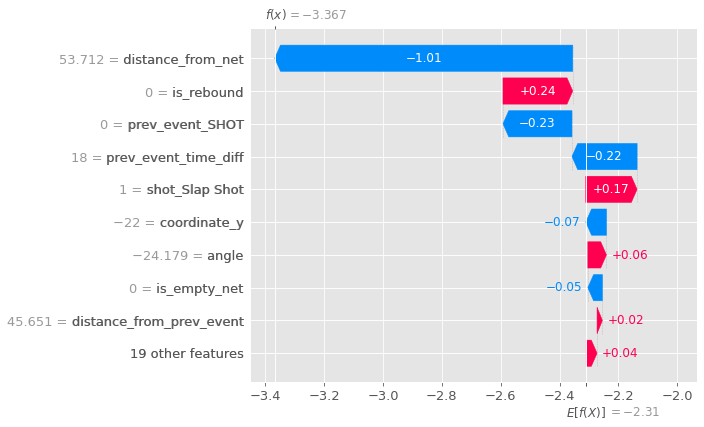

In [30]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(clf)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[88])

In [31]:
shap_feats = ['distance_from_net',
                'is_rebound',
                'prev_event_SHOT',
                'prev_event_time_diff',
                'angle',
                'is_empty_net',
                'shot_Snap Shot',
                'shot_Slap Shot',
                'distance_from_prev_event',
                'coordinate_y',
                'prev_event_HIT']

In [39]:
X_train_shap, X_val_shap = X_train[shap_feats], X_val[shap_feats]

### Tune hparams for SHAP selected features

In [48]:
# # hparams tuning with selected lasso features
# clf_optimal_shap = get_xgboost_hparams_tuning(X_train_shap, Y_train,
#                                  feat_select_method_name = "hparams_shap",
#                                  save_result_path="/home/sara/Downloads/DS_xgboost/")

In [43]:
hparam_search_ranges = {
        "n_estimators": randint(100, 500),
        "max_depth": randint(1, 6),
        "colsample_bytree": uniform(.33, 1-.33),
        "subsample": uniform(0.5, 1-.5),
        "learning_rate": uniform(0.03, .67-.03),
        "gamma": uniform(0, 0.5)
    }
opt_params={key:getattr(clf_optimal_shap, key) for key in hparam_search_ranges}

In [44]:
opt_params

{'n_estimators': 495,
 'max_depth': 5,
 'colsample_bytree': 0.5395748217887331,
 'subsample': 0.9262101866374273,
 'learning_rate': 0.06161853852618868,
 'gamma': 0.18476657843168925}

In [45]:
# hparams tuned on SHAP selected features
params = {
    'max_depth':5 , 'n_estimators': 495, 'learning_rate': 0.062, 'gamma': 0.184,
    'objective':'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False
}

clf_lasso = xgb.XGBClassifier(**params)
clf_lasso.fit(X_train_shap, Y_train)

y_pred = clf_lasso.predict(X_val_shap)
y_proba = clf_lasso.predict_proba(X_val_shap)[:,1]
res = pd.DataFrame({
    'y_true': Y_val,
    'y_preds': y_pred,
    'y_proba': y_proba
})

exp_name = "xgboost_feats_shap_tuned"
res.to_csv(f"/home/sara/Downloads/DS_xgboost/{exp_name}.csv", index=False)

perf_metrics = clf_performance_metrics(Y_val, y_pred, y_proba, verbose=True)

INFO:root:Accuracy is  0.921
INFO:root:Confusion Matrix:
 [[45983   149]
 [ 3864   965]]
INFO:root:F1 score is  0.325
INFO:root:Precision score is  0.866
INFO:root:Recall score is  0.200


# Visualizing XGBoost models

In [8]:
import sys
import pandas as pd

sys.path.insert(0,'../src/training/')
from visuals import generate_shot_classifier_charts

In [11]:
def generate_adv_model_figures():
    experiment_prediction_filenames = {
        "xgboost_baseline": "../models/predictions/xgboost_baseline.csv",
        "xgboost_optimal": "../models/predictions/xgboost_optimal.csv",
        "xgboost_lasso": "../models/predictions/xgboost_lasso.csv",
        "xgboost_shap": "../models/predictions/xgboost_SHAP.csv",
    }

    exp_preds = {exp: pd.read_csv(fname) for exp, fname in experiment_prediction_filenames.items()}

    exp_names, y_trues, y_preds, y_probas = [], [], [], []
    for exp, preds in exp_preds.items():
        exp_names.append(exp)
        y_trues.append(preds['y_true'].values)
        y_preds.append(preds['y_preds'].values)
        y_probas.append(preds['y_proba'].values)

    title = "Visual Summary - XGBoost Models"
    image_dir = "/home/sara/Downloads/DS_figures/"

    generate_shot_classifier_charts(
        y_trues, y_preds, y_probas, exp_names,
        title=title, image_dir=image_dir
    )

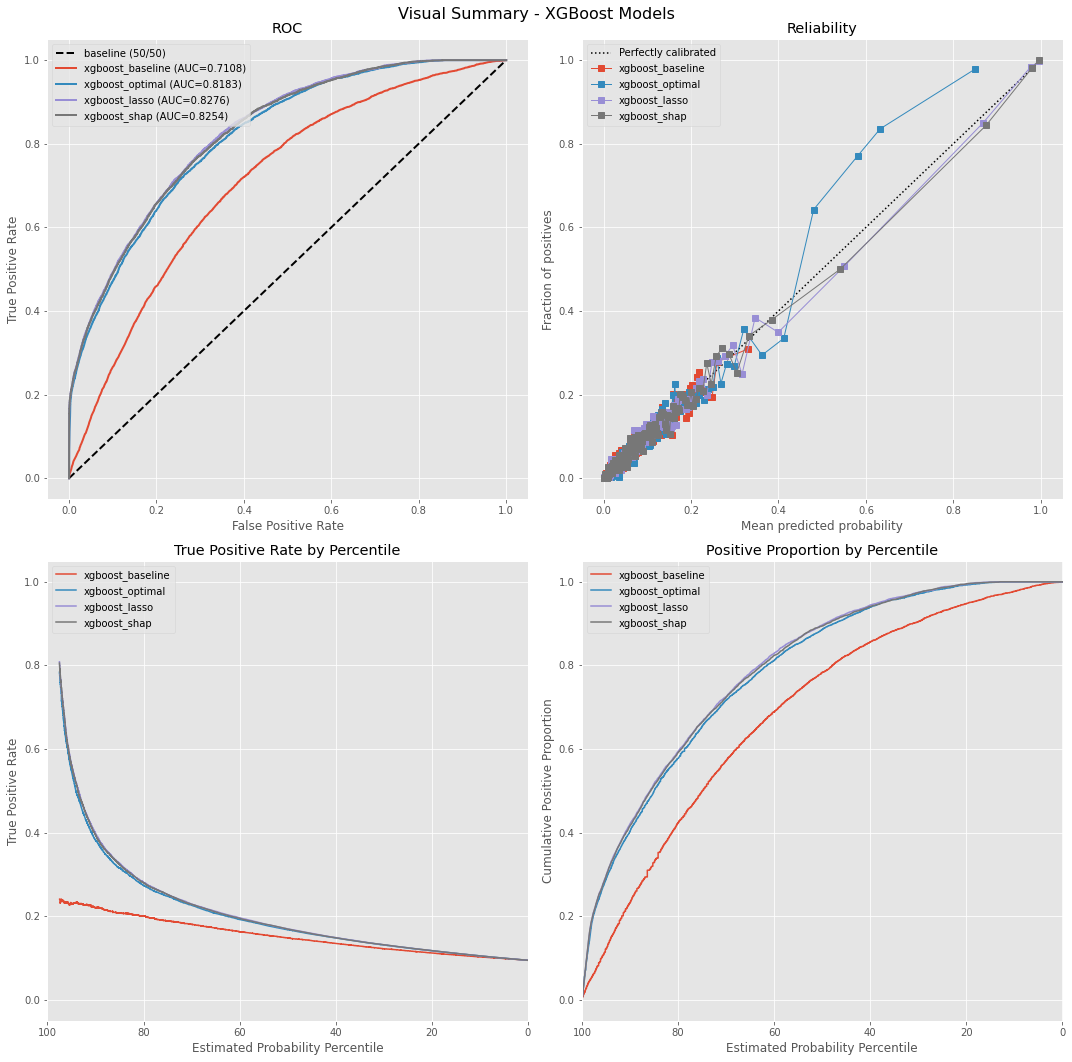

In [12]:
generate_adv_model_figures()

In [ ]:
def generate_adv_model_figures():
    experiment_prediction_filenames = {
        "xgb_distance_and_angle_only": "/home/sara/Downloads/DS_xgboost/xgboost_distance_angle_only.csv",
        "xgboost_optimal": "/home/sara/Downloads/DS_xgboost/xgboost_optimal.csv",
        # "xgboost_feats_lasso": "/home/sara/Downloads/DS_xgboost/xgboost_feats_lasso.csv",
        "xgboost_feats_lasso_tuned": "/home/sara/Downloads/DS_xgboost/xgboost_feats_lasso_tuned.csv",
        # "xgboost_feats_shap": "/home/sara/Downloads/DS_xgboost/xgboost_feats_shap.csv",
        "xgboost_feats_shap_tuned": "/home/sara/Downloads/DS_xgboost/xgboost_feats_shap_tuned.csv",

    }

    exp_preds = {exp: pd.read_csv(fname) for exp, fname in experiment_prediction_filenames.items()}

    exp_names, y_trues, y_preds, y_probas = [], [], [], []
    for exp, preds in exp_preds.items():
        exp_names.append(exp)
        y_trues.append(preds['y_true'].values)
        y_preds.append(preds['y_preds'].values)
        y_probas.append(preds['y_proba'].values)

    title = "Visual Summary - XGBoost Models"
    image_dir = "/home/sara/Downloads/DS_figures/"

    generate_shot_classifier_charts(
        y_trues, y_preds, y_probas, exp_names,
        title=title, image_dir=image_dir
    )